In [1]:
# load libraries and code
#import gdown
import matplotlib.pyplot as plt
import numpy as np
#import os
import pandas as pd
import pyro
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
#import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
from pyro.optim import Adam
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
print(torch.cuda.is_available())


sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, facecolor='white', )

enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc_ct = LabelEncoder()

adata = sc.read("./data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad",)
# keep a second copy in the original state
adatac = sc.read("./data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad",)


True
True
True
True
True
True
scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [2]:
adata = sc.read("./data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad",)


data = torch.FloatTensor(adata.X.toarray())
enc_ct.fit(adata.obs["Granular cell type"])
labels = torch.IntTensor(
        enc_ct.transform(adata.obs["Granular cell type"]))
labels = F.one_hot(labels.long(), num_classes=enc_ct.classes_.size).float()
dataset = ut.SynteticDataSet(data, labels)
data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=256,
        shuffle=True,
        )

#dataset = ut.SynteticDataSet(data, labels)
labeled_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[:1600], labels[:1600]),
        batch_size=256,
        shuffle=True,
        )
unlabeled_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[1600:-1500], labels[1600:-1500]),
        batch_size=256,
        shuffle=True,
        )
test_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(data[-1500:], labels[-1500:]),
        batch_size=256,
        shuffle=True,
        )


In [3]:
adata

AnnData object with n_obs × n_vars = 209126 × 17695
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', '

In [4]:
model = M7.VAE_Dirichlet_Type705(nx=adata.n_vars, nh=1024,
        nz=64, nw=15, nclasses=enc_ct.classes_.size,)
model.apply(init_weights)

M6.basicTrain(model, unlabeled_loader, test_loader, num_epochs=20,
        wt=0, lr=1e-3,)


training phase
rec: 19176.091796875
loss_p: 1.1667816638946533
loss_z: 38.932334899902344
loss_w: 7.626861095428467
loss_l: 0.15052483975887299
loss_l_alt: 0.47239208221435547
loss_y: -0.09585587680339813
loss_d: 2199.490966796875
loss_y_alt: 1.9371325969696045
total_loss: 21424.078125

training phase
rec: 9423.29296875
loss_p: 16.26413917541504
loss_z: 11.462244033813477
loss_w: 3.6941070556640625
loss_l: 0.9757890701293945
loss_l_alt: 4.010919094085693
loss_y: -0.8821523189544678
loss_d: 0.0
loss_y_alt: 16.072383880615234
total_loss: 9454.521484375

training phase
rec: 5086.63525390625
loss_p: 16.45640754699707
loss_z: 14.765905380249023
loss_w: 3.9228515625
loss_l: 0.9268113374710083
loss_l_alt: 4.201826095581055
loss_y: -0.9611135721206665
loss_d: 0.0
loss_y_alt: 16.056781768798828
total_loss: 5121.380859375

training phase
rec: 3210.4423828125
loss_p: 16.869529724121094
loss_z: 13.860487937927246
loss_w: 3.9305803775787354
loss_l: 1.0145397186279297
loss_l_alt: 4.238006591796875
l

In [5]:
M6.basicTrain(model, unlabeled_loader, test_loader, num_epochs=2,
        wt=0, lr=1e-3,)


training phase
rec: 1801.048828125
loss_p: 16.849172592163086
loss_z: 15.256879806518555
loss_w: 4.366156101226807
loss_l: 0.9020106196403503
loss_l_alt: 4.272294998168945
loss_y: -0.9883377552032471
loss_d: 0.0
loss_y_alt: 15.728578567504883
total_loss: 1836.4005126953125

training phase
rec: 1626.1611328125
loss_p: 16.83173942565918
loss_z: 15.307403564453125
loss_w: 4.279663562774658
loss_l: 0.905132532119751
loss_l_alt: 4.266747951507568
loss_y: -0.9847276210784912
loss_d: 0.0
loss_y_alt: 16.25030517578125
total_loss: 1661.99853515625



In [6]:
model.eval()
output = model(data)
adata.obsm["z_gmmdvae"] = output["z"].detach().numpy()
adata.obs["predict_gmmdvae"] = output["q_y"].detach().argmax(-1).numpy().astype(str)


In [7]:
sc.pp.neighbors(adata, use_rep="z_gmmdvae", n_neighbors=10,)
sc.tl.umap(adata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:22)


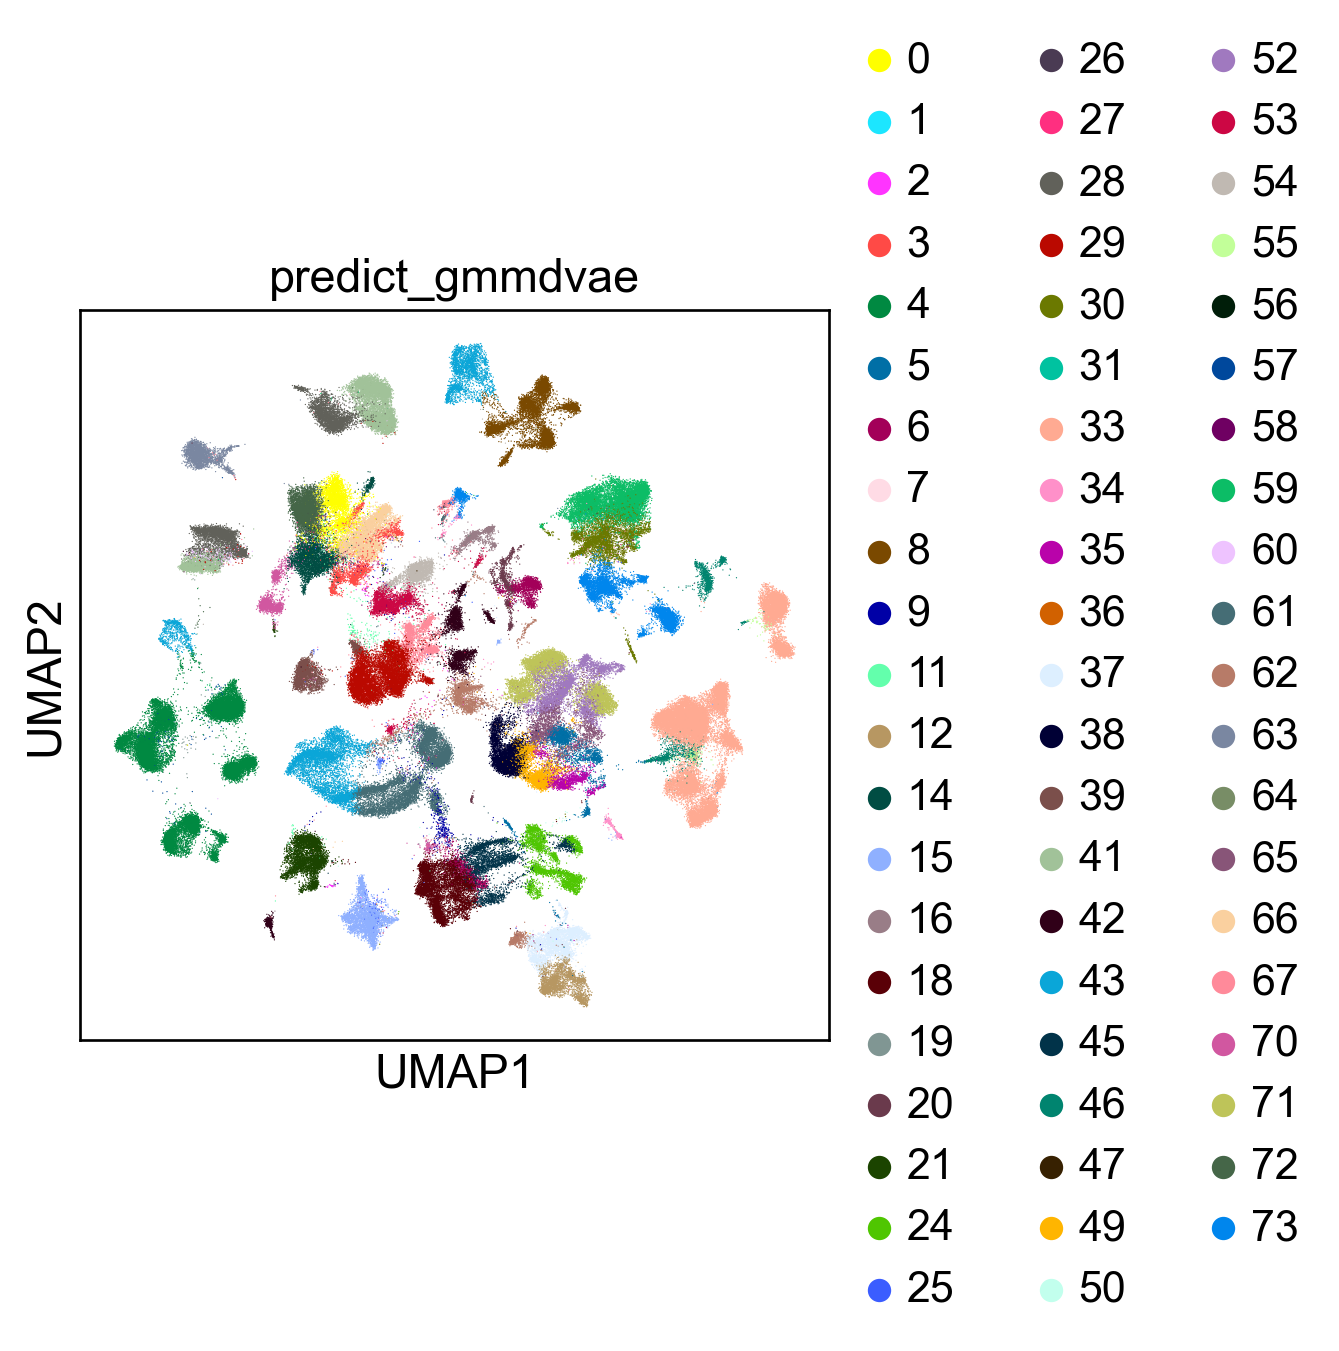

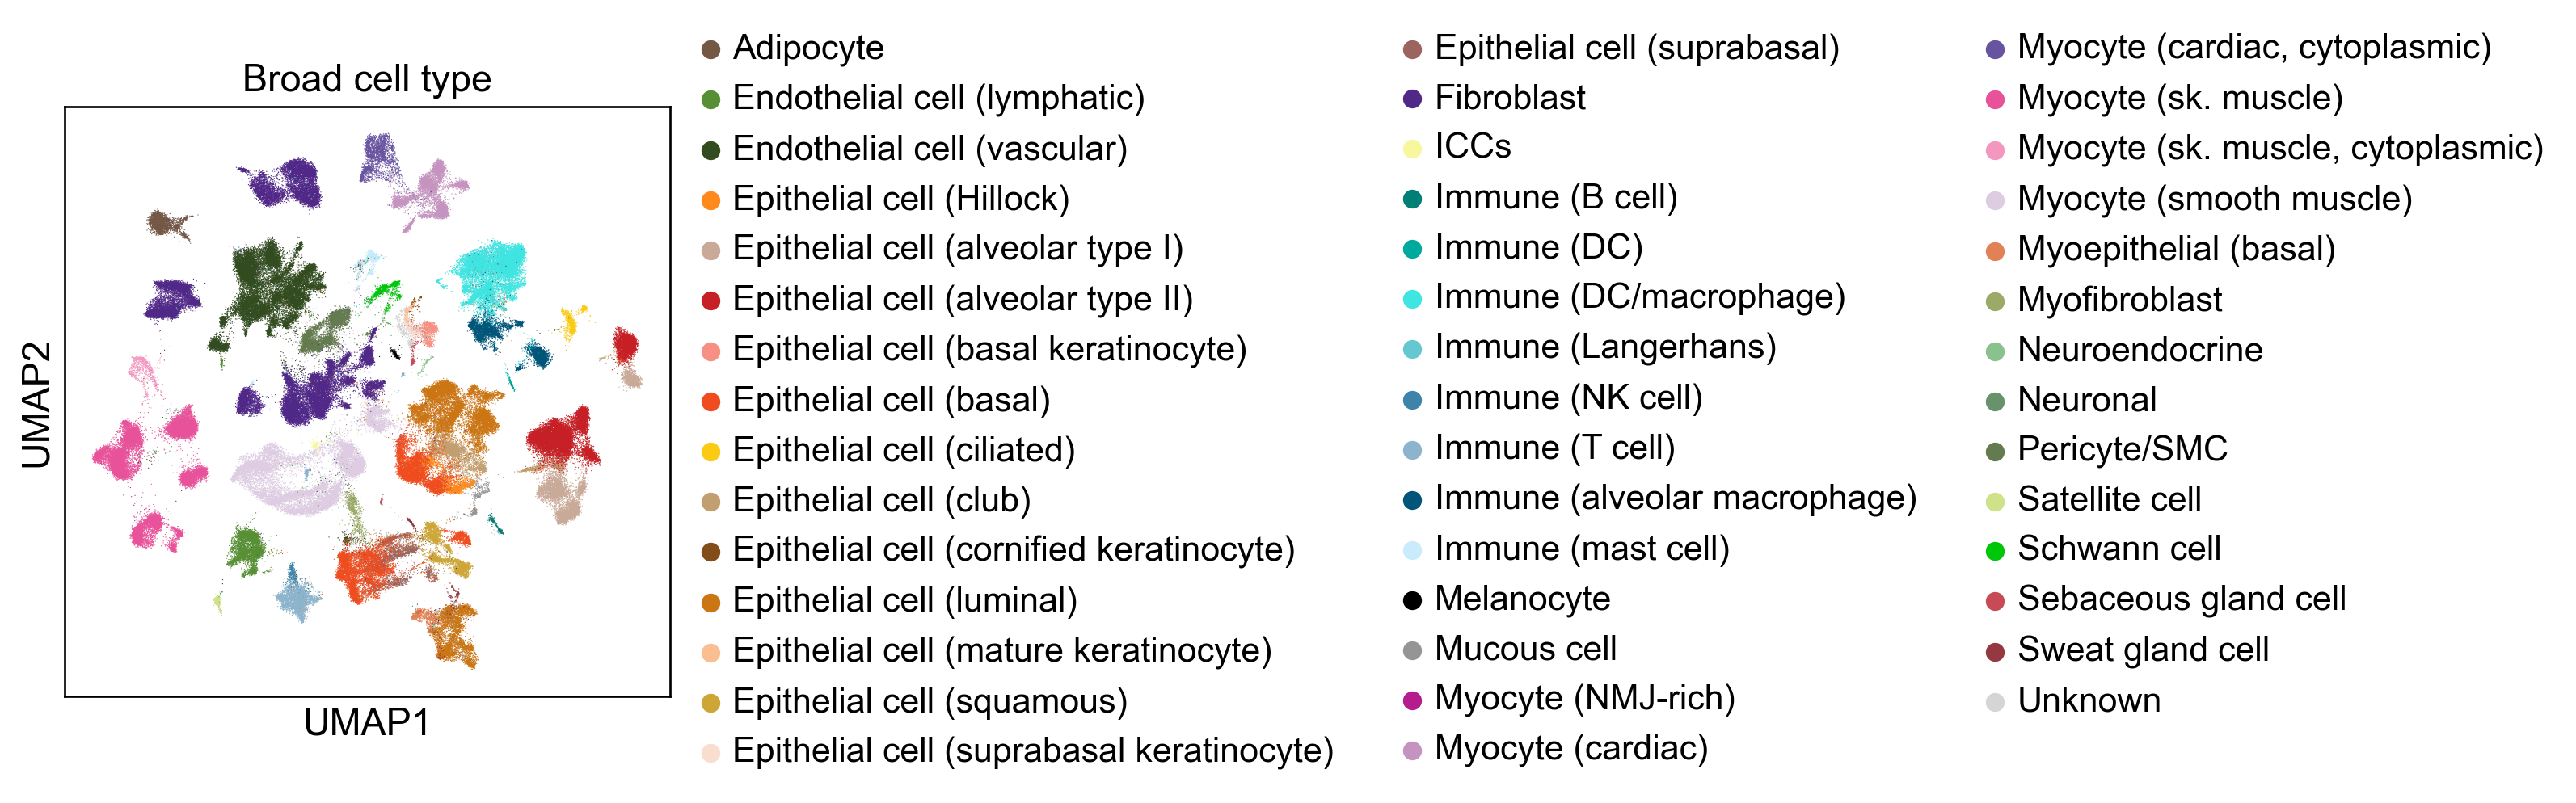

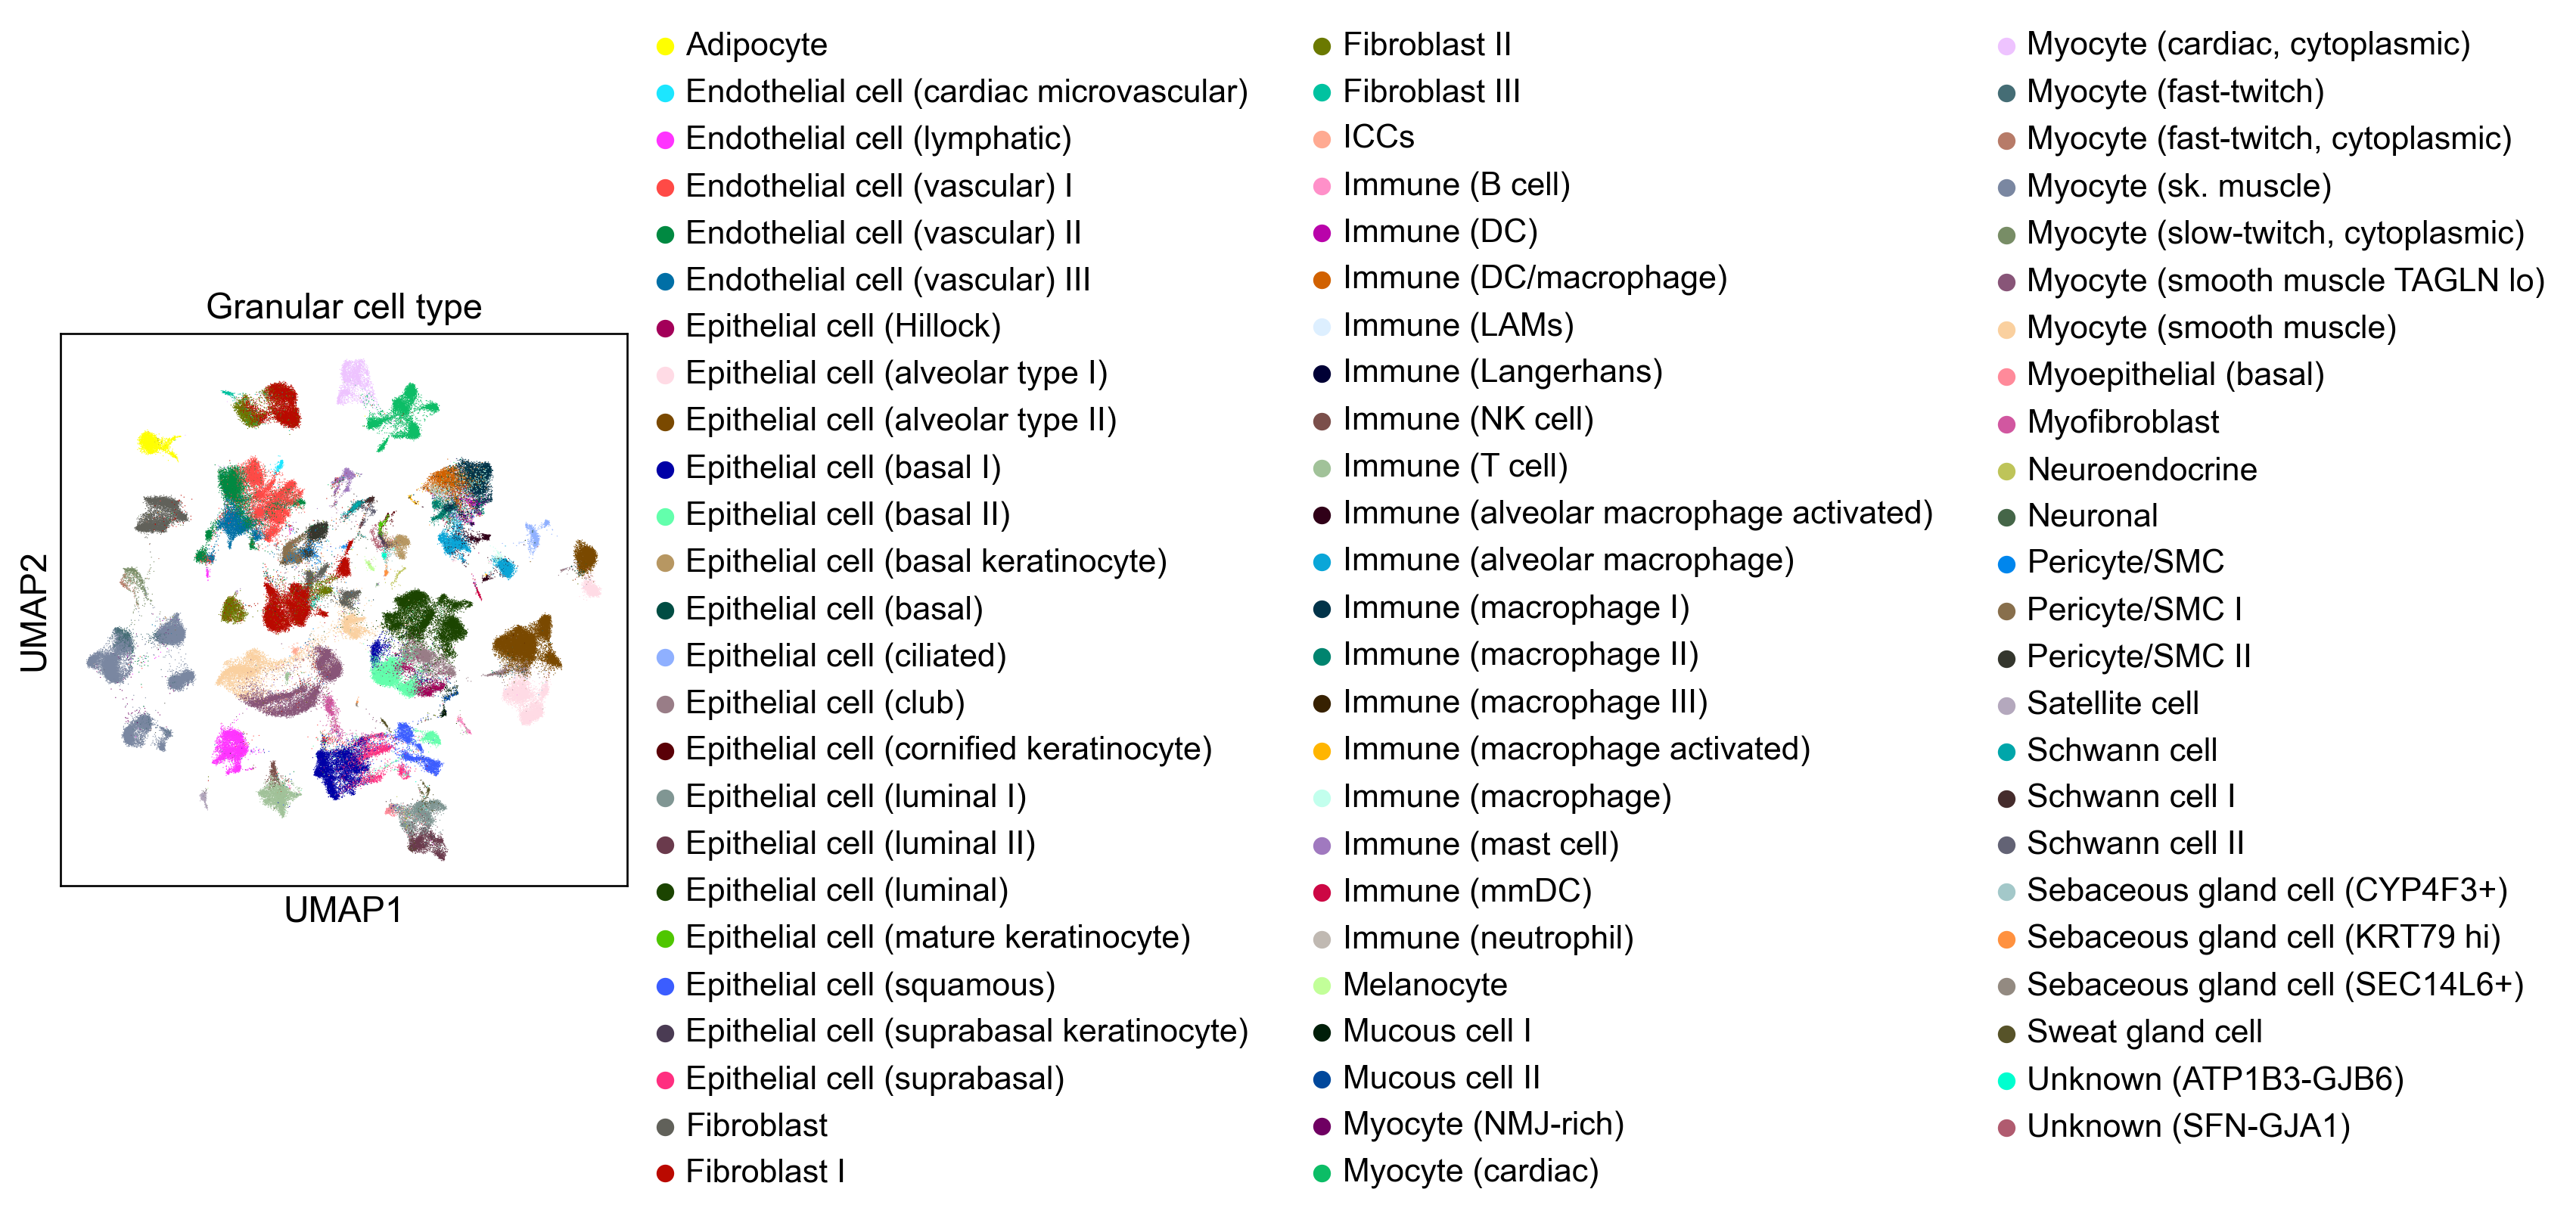

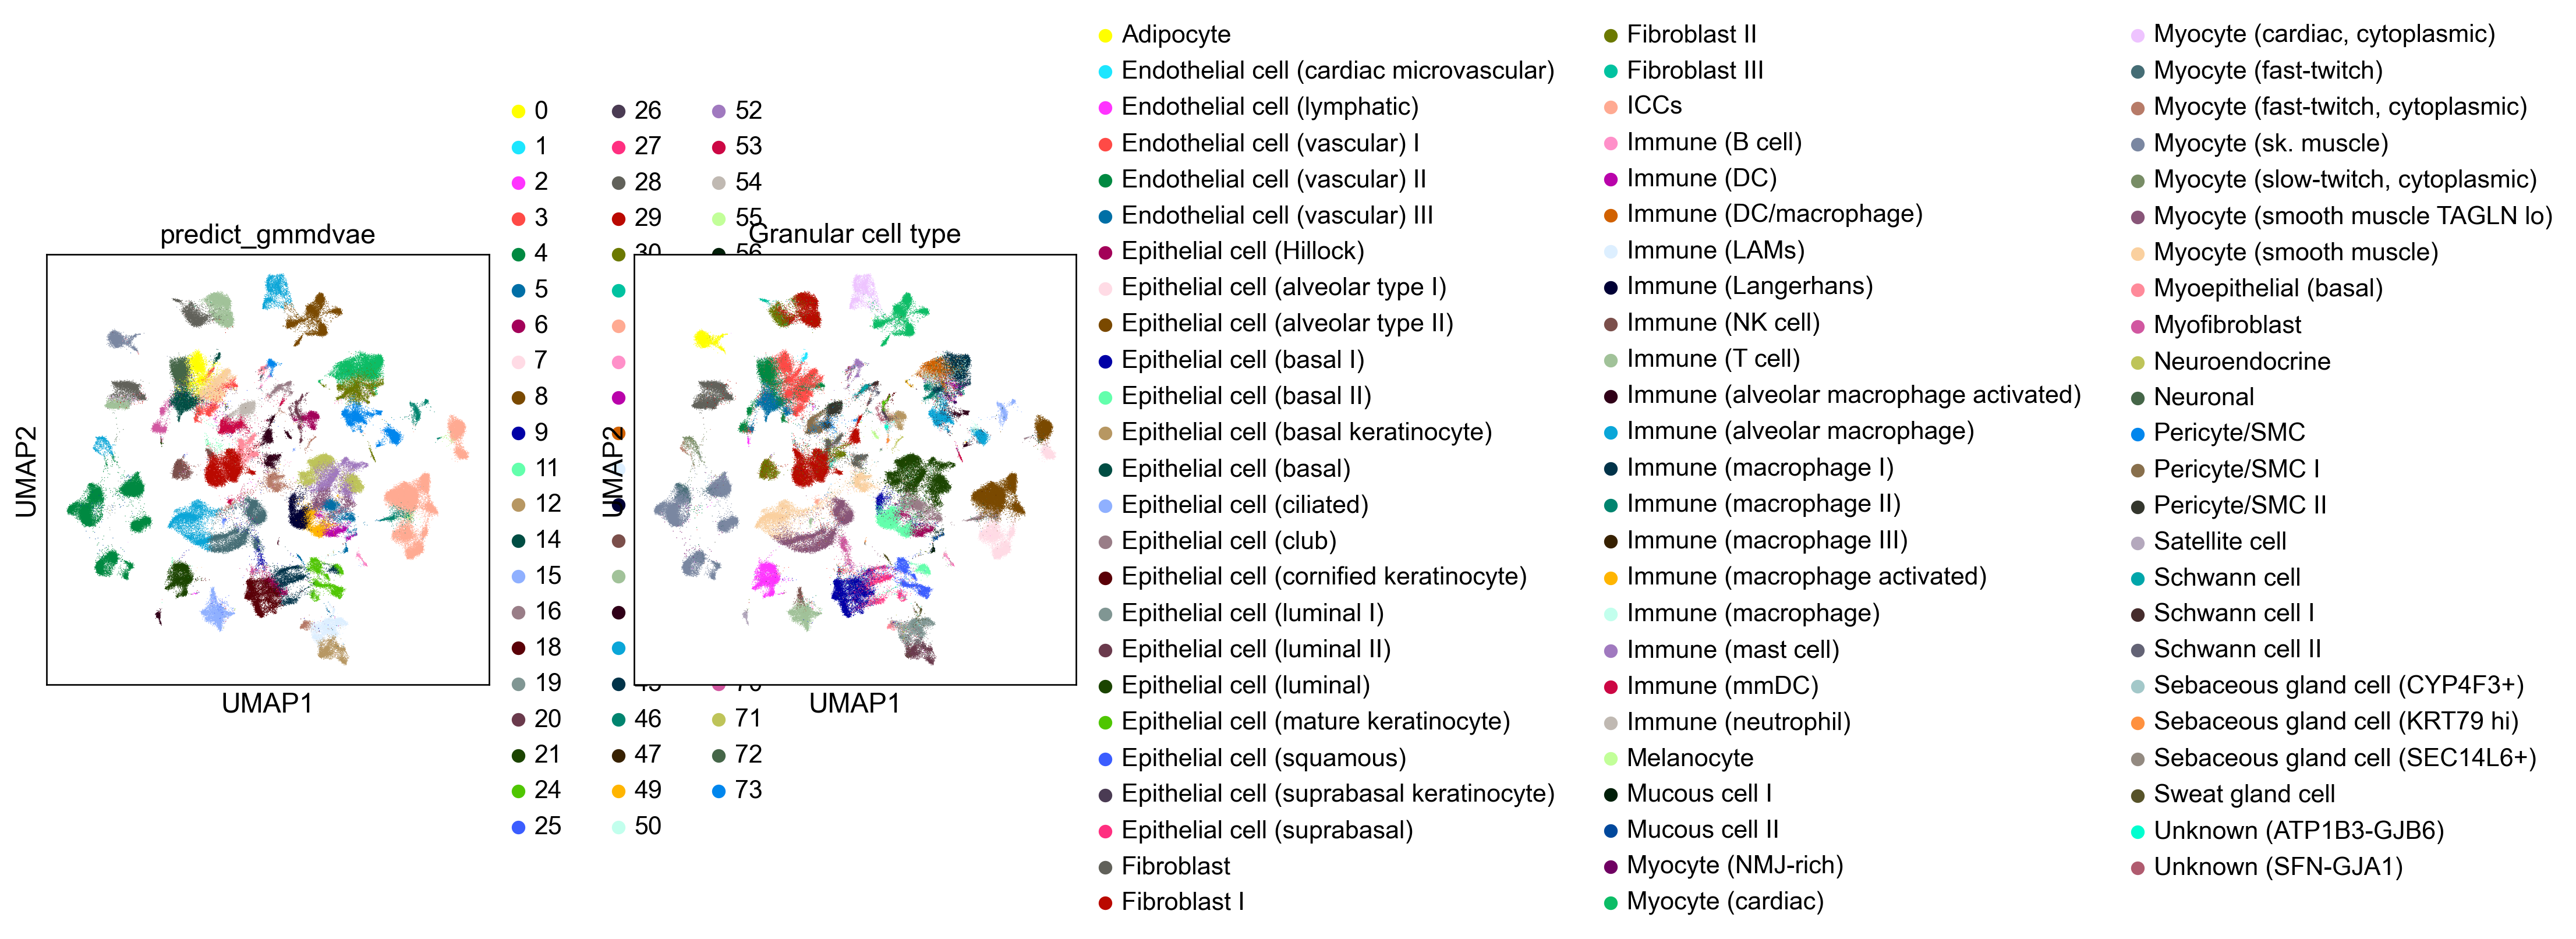

In [11]:
sc.pl.umap(adata, color=["predict_gmmdvae",], )
sc.pl.umap(adata, color=["Broad cell type",], )
sc.pl.umap(adata, color=["Granular cell type",], )

sc.pl.umap(adata, color=["predict_gmmdvae", "Granular cell type",], )

In [13]:
output["q_y"].sum(0)

tensor([3.6995e+03, 3.1625e+00, 9.7172e+01, 2.0512e+03, 2.0838e+04, 2.1776e+03,
        2.4889e+03, 1.4336e+00, 6.6912e+03, 4.5812e+02, 5.2273e-03, 3.0211e+02,
        2.4593e+03, 5.1148e-01, 3.7308e+03, 3.9308e+03, 1.3215e+03, 4.9521e-01,
        6.2202e+03, 5.9492e+01, 1.0490e+03, 4.4081e+03, 5.2093e-03, 1.0697e-02,
        3.2107e+03, 2.6586e+02, 1.4160e+02, 9.2479e+01, 6.4203e+03, 9.5927e+03,
        3.8431e+03, 6.4738e+00, 5.9643e-03, 2.2082e+04, 4.6773e+02, 1.4315e+03,
        6.2413e+00, 3.1628e+03, 4.3574e+03, 2.8633e+03, 1.3129e-02, 8.6111e+03,
        3.2904e+03, 8.4200e+03, 1.6435e-02, 3.1298e+03, 1.6679e+03, 2.7011e+00,
        2.5882e-02, 3.0953e+03, 4.9175e+01, 8.4882e-01, 4.4934e+03, 3.0406e+03,
        2.2444e+03, 3.2838e+02, 1.8951e+01, 1.4445e+02, 5.5841e+01, 9.0373e+03,
        3.2836e+02, 8.6166e+03, 2.4455e+03, 2.3077e+03, 2.9863e+00, 2.3514e+03,
        4.8284e+03, 2.7296e+03, 3.0059e-02, 4.0093e-01, 1.9913e+03, 5.7301e+03,
        4.3113e+03, 5.9192e+03], grad_fn